In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Symbolic Math
The following is symbolic math for LaTex.

## State Vector

Constant Velocity Model for Ego Motion

$$x_k= \left[ \matrix{ x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z} \right] = \matrix{ \text{X position} \\ \text{Y position} \\ \text{Z position} \\ \text{X velocity} \\ \text{Y velocity}\\ \text{Z velocity}}$$

Formal definition

$$x_{k+1} = \begin{bmatrix}1 & 0 & 0 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 & \Delta t & 0 \\ 0 & 0 & 1 & 0 & 0 & \Delta t \\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z \end{bmatrix}_{k}$$

Observation model
$$y = H \cdot x$$

### Process Noise Covariance Matrix $Q$ for CV Model

The velocity of the tracked object has the possability of changing over time, such as changing directions. This is known as process noise, $Q$. $Q$ can be calculated as
$$Q = G\cdot G^T \cdot \sigma_v^2$$
with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & 0.5dt^2 & dt & dt & dt\end{bmatrix}^T$ and $\sigma_v$ as the velocity process noise.

In [54]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('\Delta t')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[0.5*dts**2],[dts],[dts],[dts]])
Qs*Qs.T

⎡             4               4               4              3              3 
⎢0.25⋅\Delta t   0.25⋅\Delta t   0.25⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t  
⎢                                                                             
⎢             4               4               4              3              3 
⎢0.25⋅\Delta t   0.25⋅\Delta t   0.25⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t  
⎢                                                                             
⎢             4               4               4              3              3 
⎢0.25⋅\Delta t   0.25⋅\Delta t   0.25⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t  
⎢                                                                             
⎢            3               3               3             2              2   
⎢0.5⋅\Delta t    0.5⋅\Delta t    0.5⋅\Delta t      \Delta t       \Delta t    
⎢                                                                             
⎢            3               3               3      

### Measurement Matrix $H$

$$H = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix}$$

### Measurement Noise Covariance $R$

Tells the Kalman Filter how 'bad' the sensor readings are.

$$R = \begin{bmatrix}\sigma^2_{\dot x} & 0 & 0 \\ 0 & \sigma^2_{\dot y} & 0 \\  0 & 0 & \sigma^2_{\dot z}\end{bmatrix}$$

### Dynamic Matrix $A$

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t$$
$$z_{k+1} = z_{k} + \dot z_{k} \cdot \Delta t$$
$$\dot x_{k+1} = \dot x_{k}$$
$$\dot y_{k+1} = \dot y_{k}$$
$$\dot z_{k+1} = \dot z_{k}$$

### Initial State $x_0$

$$x_{0} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$

### Initial Uncertainty $P_0$

$$P_{0} = \begin{bmatrix}
\sigma^2_x & 0 & 0 & 0 & 0 & 0 \\ 
0 & \sigma^2_y & 0 & 0 & 0 & 0 \\ 
0 & 0 & \sigma^2_z & 0 & 0 & 0 \\ 
0 & 0 & 0 & \sigma^2_{\dot x} & 0 & 0 \\ 
0 & 0 & 0 & 0 & \sigma^2_{\dot y} & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma^2_{\dot z}
\end{bmatrix}$$

with $\sigma$ as the standard deviation

### Kalman Prediction Step
Project the state ahead
$$x_{k+1}=A\cdot x_k$$
Project the error covariance ahead
$$P_{k+1} = A\cdot P_k\cdot A^T + Q$$

### Kalman Correction Step
Compute the Kalman gain $K$
$$S_k=H_k\cdot P_k\cdot H_k^T+R_k$$
$$K_k=(P_k\cdot H_k^T)S_k^{-1}$$

Update the estimate via z
$$y_k=Z_k-(H_k\cdot x)$$
$$x_k=x_k+(K_k\cdot y)$$

Update the error covariance
$$P_k=(I_k-(K_k\cdot H_k))P$$

## Setup Matrices

In [55]:
dt = 0.1  # delta time
sp = 1.5 # Sigma for position noise

# initial state
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
# initial uncertainty
P = 100.0*np.eye(6)
# dynamic matrix
A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, dt, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0, dt],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
# measurement matrix
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
# measurement noise covariance
ra = 1.5
R = np.matrix([[ra, 0.0, 0.0],
              [0.0, ra, 0.0],
              [0.0, 0.0, ra]])
# process noise covariance
sv =0.0
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [dt]])
Q = G*G.T*sv
# identity matrix
I = np.eye(6)


### Process Noise Covariance $Q$

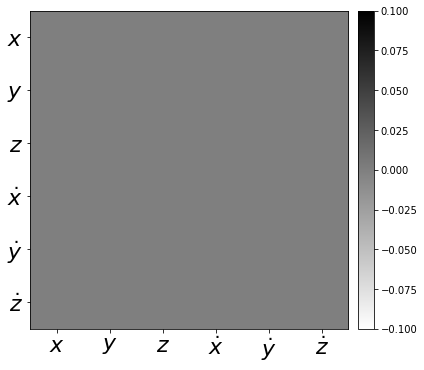

In [56]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
# plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(4))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()
plt.savefig('KF_process_noise.png', dpi=150, bbox_inches='tight')

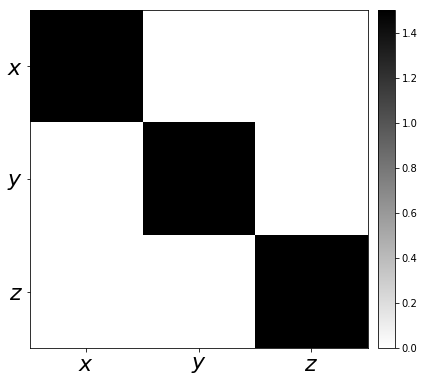

In [57]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
# plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(4))
# set the locations and labels of the yticks
plt.yticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(4))
# set the locations and labels of the yticks
plt.xticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)

plt.xlim([-0.5,2.5])
plt.ylim([2.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.savefig('KF_measurement_noise.png', dpi=150, bbox_inches='tight')

In [58]:
T = 100.0 # s measuremnt time
m = int(T/dt) # number of measurements

px= 0.0 # x Position Start
py= 0.0 # y Position Start
pz= 0.0 # z Position Start

vx = 0.0 # m/s Velocity
vy = 0.0 # m/s Velocity
vz = 0.0 # m/s Velocity

Xr=[]
Yr=[]
Zr=[]

for i in range(m):
    px += vx*i*dt
    py += vy*i*dt
    pz += vz*i*dt
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)

In [59]:
# Skewed along the x-axis
Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

In [60]:
measurements = np.vstack((Xm,Ym,Zm))

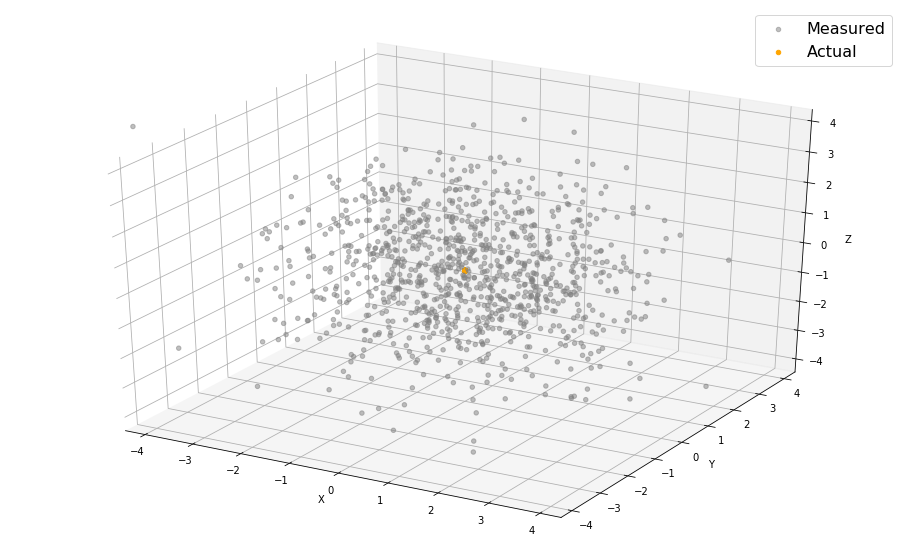

In [76]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cXm,cYm,cXm, label='Camera Measured Position')
ax.scatter(Xm, Ym, Zm, c='gray', label='Measured', alpha=0.5)
ax.scatter(Xr, Yr, Zr, c='orange', label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# plt.title('Target Position Observed from Computer Vision System (with Noise)')
plt.legend(prop={'size':16})

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(),Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 2.5
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)

plt.savefig('KF_position_result.png', dpi=150, bbox_inches='tight')

In [62]:
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []

for n in range(len(measurements[0])):
    
    # Adaptive Measurement Covariance R from last i Measurements
    # as an Maximum Likelihood Estimation
#     i = 50
#     if n>i:
#         R = np.matrix([[np.std(measurements[0,(n-i):n])**2, 0.0, 0.0],
#                       [0.0, np.std(measurements[1,(n-i):n])**2, 0.0],
#                       [0.0, 0.0, np.std(measurements[2,(n-i):n])**2]])
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x 
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))

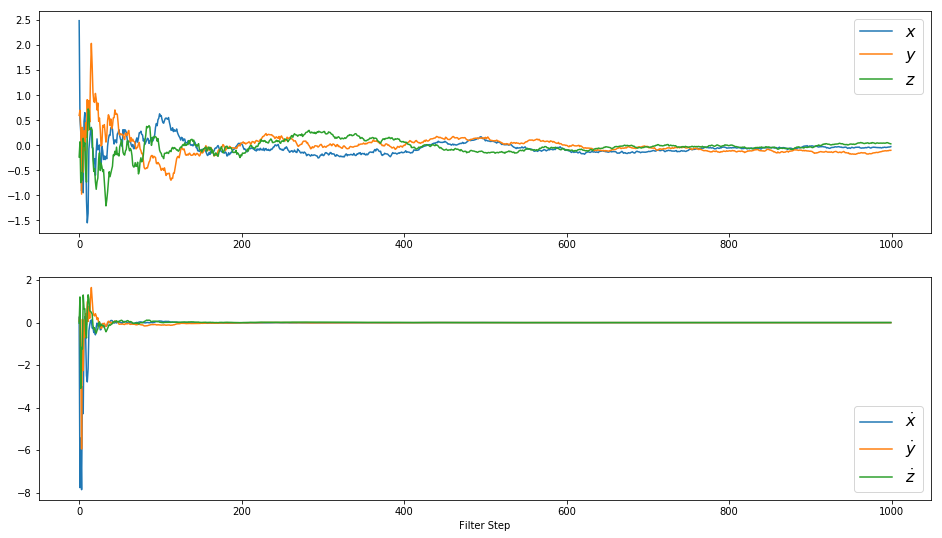

In [63]:
fig = plt.figure(figsize=(16,9))
plt.subplot(211)
# plt.title('Estimated State (elements from vector $x$)')
plt.plot(range(len(measurements[0])),xt, label='$x$')
plt.plot(range(len(measurements[0])),yt, label='$y$')
plt.plot(range(len(measurements[0])),zt, label='$z$')
plt.legend(loc='best',prop={'size':16})

plt.subplot(212)
plt.plot(range(len(measurements[0])),dxt, label='$\dot x$')
plt.plot(range(len(measurements[0])),dyt, label='$\dot y$')
plt.plot(range(len(measurements[0])),dzt, label='$\dot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':16})
plt.savefig('KF_estimated_state.png', dpi=150, bbox_inches='tight')

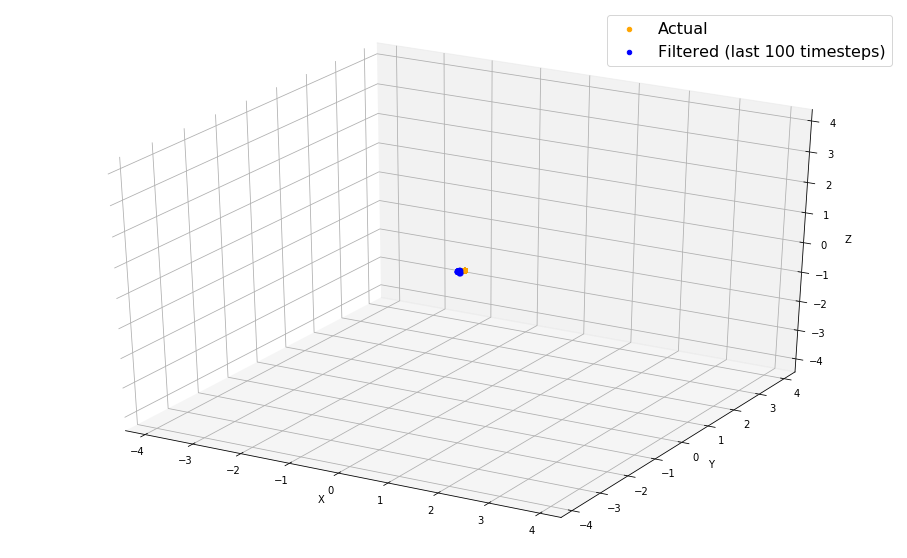

In [72]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cXm,cYm,cXm, label='Camera Measured Position')
# ax.scatter(Xm, Ym, Zm, c='gray', label='Measured')
ax.scatter(Xr, Yr, Zr, c='orange', label='Actual')
ax.scatter(xt[-100:], yt[-100:], zt[-100:], c='blue', label='Filtered (last 100 timesteps)', zorder=100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# plt.title('Target Position Observed from Computer Vision System (with Noise)')
plt.legend(prop={'size':16})

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(),Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 2.5
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.savefig('KF_position_result.png', dpi=150, bbox_inches='tight')

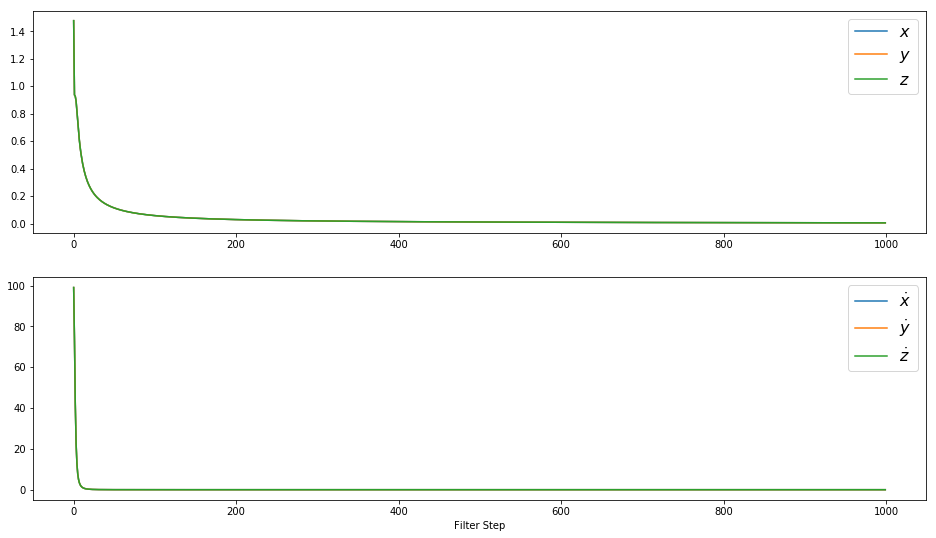

In [77]:
fig = plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(range(len(measurements[0])),Px, label='$x$')
plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pz, label='$z$')
# plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':16})
plt.subplot(212)
plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')
plt.plot(range(len(measurements[0])),Pdz, label='$\dot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':16})
plt.savefig('CF_uncertainty.png', dpi=150, bbox_inches='tight')

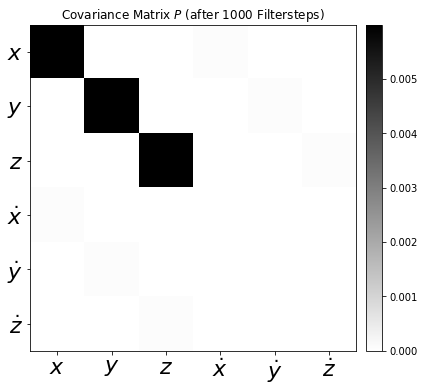

In [66]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filtersteps)' % m)
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()
plt.savefig('KF_covariance_100ts.png', dpi=150, bbox_inches='tight')

### Kalman Gains

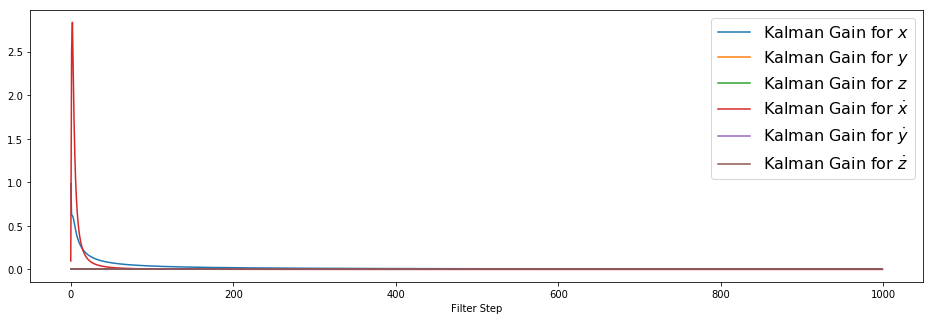

In [70]:
fig = plt.figure(figsize=(16,5))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kz, label='Kalman Gain for $z$')
plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')
plt.plot(range(len(measurements[0])),Kdz, label='Kalman Gain for $\dot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
# plt.title('Kalman Gain')
plt.legend(loc='best',prop={'size':16})
plt.savefig('KF_gain.png', dpi=150, bbox_inches='tight')